# 가변 길이 인수 (순전파)

In [1]:
import numpy as np

In [2]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{}은(는) 지원하지 않습니다.'.format(type(data)))
        self.data = data
        self.grad = None
        self.creator = None
        
    def set_creator(self, func):
        self.creator = func
        
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 함수를 가져온다.
            x, y = f.input, f.output # 함수의 입력과 출력을 가져온다.
            x.grad = f.backward(y.grad) # backward 메서드를 호출한다.
            
            if x.creator is not None:
                funcs.append(x.creator) # 하나 앞의 함수를 리스트에 추가한다.

In [3]:
class Function:
    def __call__(self, input):
        x = input.data
        y = self.forward(x)
        output = Variable(as_array(y))
        output.set_creator(self)
        self.input = input
        self.output = output
        return output
    
    def forward(self, x):
        raise NotImplementedError()
        
    def backward(self, gy):
        raise NotImplementedError()

In [4]:
class Function:
    def __call__(self, inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(xs)
        outputs = [Variable(as_array(y)) for y in ys]
        
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        return outputs
    
    def forward(self, x):
        raise NotImplementedError()
        
    def backward(self, gy):
        raise NotImplementedError()

In [5]:
def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

가변 길이 입출력을 표현하기 위해 리스트 형태로 변경하였다.

In [10]:
class Add(Function):
    def forward(self, xs):
        x0, x1 = xs
        y = x0 + x1
        return (y,)

In [7]:
xs = [Variable(np.array(2)), Variable(np.array(3))] # 리스트로 준비
f = Add()
ys = f(xs) # ys 튜플
y = ys[0]
print(y.data)

5


입력을 이스트로 바꿔서 여러 개의 변수를 다룰 수 있다.
출력은 튜플로 바꿔서 역시 여러 개의 변수에 대응할 수 있다.

하지만, Add 클래스를 사용하는 사람에게 입력 변수를 리스트에 담아 건네주라고 요구하거나 반환값으로 튜플을 받게 하는 것은 자연스럽지 않다.

# 가변 길이 인수 (개선)
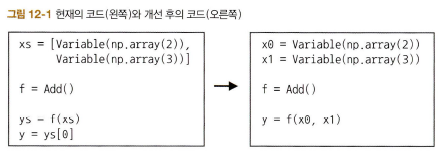

함수를 사용하기 쉽게

In [8]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(xs)
        outputs = [Variable(as_array(y)) for y in ys]
        
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        # 리스트의 원소가 하나라면 첫 번째 원소를 반환
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, x):
        raise NotImplementedError()
        
    def backward(self, gy):
        raise NotImplementedError()

In [11]:
x0 = Variable(np.array(2))
x1 = Variable(np.array(3))
f = Add()
y = f(x0, x1)
print(y.data)

5


함수를 구현하기 쉽도록

In [12]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs) # 언팩
        if not isinstance(ys, tuple): # 튜플이 아닌 경우 추가
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]
        
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        # 리스트의 원소가 하나라면 첫 번째 원소를 반환
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, x):
        raise NotImplementedError()
        
    def backward(self, gy):
        raise NotImplementedError()

In [13]:
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

In [50]:
def add(x0, x1):
    return Add()(x0, x1)

In [15]:
x0 = Variable(np.array(2))
x1 = Variable(np.array(3))
y = add(x0, x1)
print(y.data)

5


# 가변 길이 인수 (역전파)

In [51]:
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y
    def backward(self, gy):
        return gy, gy

In [52]:
def add(x0, x1):
    return Add()(x0, x1)

In [17]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{}은(는) 지원하지 않습니다.'.format(type(data)))
        self.data = data
        self.grad = None
        self.creator = None
        
    def set_creator(self, func):
        self.creator = func
        
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 함수를 가져온다.
            print("f",f)
            gys = [output.grad for output in f.outputs]
            print("gys",gys)
            gxs = f.backward(*gys)
            print("gxs",gxs)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)
                
            for x,gx in zip(f.inputs, gxs):
                x.grad = gx
                print("x, gx", x, gx)
            
                if x.creator is not None:
                    funcs.append(x.creator) # 하나 앞의 함수를 리스트에 추가한다.
                    print("x.creator",x.creator)

In [47]:
class Square(Function):
    def forward(self, x):
        y = x ** 2
        return y
    
    def backward(self, gy):
        x = self.inputs[0].data # 수정 전 : x = self.input.data
        gx = 2 * x * gy
        return gx

In [48]:
def square(x):
    return Square()(x)

In [20]:
x = Variable(np.array(2.0))
y = Variable(np.array(3.0))

z = add(square(x), square(y))
z.backward()
print(z.data)
print(z.grad)
print(x.grad)
print(y.grad)

f <__main__.Add object at 0x000001E39D926FD0>
gys [array(1.)]
gxs (array(1.), array(1.))
x, gx <__main__.Variable object at 0x000001E39D92CC70> 1.0
x.creator <__main__.Square object at 0x000001E39D9F1F40>
x, gx <__main__.Variable object at 0x000001E39D926730> 1.0
x.creator <__main__.Square object at 0x000001E39D92CD30>
f <__main__.Square object at 0x000001E39D92CD30>
gys [array(1.)]
gxs 6.0
x, gx <__main__.Variable object at 0x000001E39D9F17C0> 6.0
f <__main__.Square object at 0x000001E39D9F1F40>
gys [array(1.)]
gxs 4.0
x, gx <__main__.Variable object at 0x000001E39D9F1DF0> 4.0
13.0
1.0
4.0
6.0


# 같은 변수 반복 사용

In [21]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{}은(는) 지원하지 않습니다.'.format(type(data)))
        self.data = data
        self.grad = None
        self.creator = None
        
    def set_creator(self, func):
        self.creator = func
        
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 함수를 가져온다.
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)
                
            for x,gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
            
                if x.creator is not None:
                    funcs.append(x.creator) # 하나 앞의 함수를 리스트에 추가한다.

In [22]:
x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print(x.grad)

2.0


In [23]:
x = Variable(np.array(3.0))
y = add(add(x, x), x)
y.backward()
print(x.grad)

3.0


## 미분값 재설정

In [24]:
# 첫 번째 계산
x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print(x.grad)

# 두 번째 계산(같은 x를 사용하여 다른 계산을 수행)
y = add(add(x, x), x)
y.backward()
print(x.grad)

2.0
5.0


In [25]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{}은(는) 지원하지 않습니다.'.format(type(data)))
        self.data = data
        self.grad = None
        self.creator = None
        
    def set_creator(self, func):
        self.creator = func
    
    def cleargrad(self):
        self.grad = None
        
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 함수를 가져온다.
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)
                
            for x,gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
            
                if x.creator is not None:
                    funcs.append(x.creator) # 하나 앞의 함수를 리스트에 추가한다.

In [26]:
# 첫 번째 계산
x = Variable(np.array(3.0))
y = add(x, x)
y.backward()
print(x.grad)

# 두 번째 계산(같은 x를 사용하여 다른 계산을 수행)
x.cleargrad()
y = add(add(x, x), x)
y.backward()
print(x.grad)

2.0
3.0


# 복잡한 계산 그래프 (구현)

In [27]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{}은(는) 지원하지 않습니다.'.format(type(data)))
        
        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0 # 세대 수를 기록하는 변수
        
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 # 세대를 기록한다 (부모 세대 + 1).
    def cleargrad(self):
        self.grad = None
        
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
        funcs = [self.creator]
        while funcs:
            f = funcs.pop() # 함수를 가져온다.
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)
                
            for x,gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
            
                if x.creator is not None:
                    funcs.append(x.creator) # 하나 앞의 함수를 리스트에 추가한다.

In [28]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs) # 언팩
        if not isinstance(ys, tuple): # 튜플이 아닌 경우 추가
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]
        
        self.generation = max([x.generation for x in inputs])
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = outputs
        # 리스트의 원소가 하나라면 첫 번째 원소를 반환
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, x):
        raise NotImplementedError()
        
    def backward(self, gy):
        raise NotImplementedError()

In [29]:
generations = [2, 0, 1, 4, 2]
funcs = []

for g in generations:
    f = Function() # 더미 함수 클래스
    f.generation = g
    funcs.append(f)
    
[f.generation for f in funcs]

[2, 0, 1, 4, 2]

In [30]:
funcs.sort(key=lambda x: x.generation) # 리스트 정렬
[f.generation for f in funcs]

[0, 1, 2, 2, 4]

In [31]:
f = funcs.pop()
f.generation

4

In [32]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{}은(는) 지원하지 않습니다.'.format(type(data)))
        
        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0 # 세대 수를 기록하는 변수
        
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 # 세대를 기록한다 (부모 세대 + 1).
    def cleargrad(self):
        self.grad = None
        
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
        funcs = []
        seen_set = set()
        
        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)
                #|print("funcs",funcs)
                #print("seen_set",seen_set)
                
        add_func(self.creator)
        
        while funcs:
            f = funcs.pop() # 함수를 가져온다.
            gys = [output.grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)
                
            for x,gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
            
                if x.creator is not None:
                    add_func(x.creator) # 수정 전: funcs.append(x.creator)

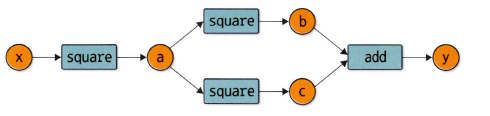

In [38]:
x = Variable(np.array(2.0))
a = square(x)
y = add(square(a), square(a))
y.backward()

print(y.data)
print(x.grad)

32.0
64.0


# 메모리 관리와 순환 참조

In [39]:
class obj:
    pass

def f(x):
    print(x)
    
a = obj() # 변수에 대입: 참조 카운트 1
f(a) # 함수에 전달: 함수 안에서는 참조 카운트 2
# 함수 완료: 빠져나오면 참조 카운트 1
a = None # 대입 해제: 참조 카운트 0

In [40]:
import weakref

a = np.array([1, 2, 3])
b = weakref.ref(a)
b

<weakref at 0x000001E39DA0FD10; to 'numpy.ndarray' at 0x000001E39DA0F0D0>

In [41]:
b()

array([1, 2, 3])

In [42]:
a = np.array([1, 2, 3])
b = weakref.ref(a)
a = None
b

<weakref at 0x000001E39DA19A90; dead>

In [43]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs) # 언팩
        if not isinstance(ys, tuple): # 튜플이 아닌 경우 추가
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]
        
        self.generation = max([x.generation for x in inputs])
        for output in outputs:
            output.set_creator(self)
        self.inputs = inputs
        self.outputs = [weakref.ref(output) for output in outputs]
        # 리스트의 원소가 하나라면 첫 번째 원소를 반환
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, x):
        raise NotImplementedError()
        
    def backward(self, gy):
        raise NotImplementedError()

In [44]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{}은(는) 지원하지 않습니다.'.format(type(data)))
        
        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0 # 세대 수를 기록하는 변수
        
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 # 세대를 기록한다 (부모 세대 + 1).
    def cleargrad(self):
        self.grad = None
        
    def backward(self):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
        funcs = []
        seen_set = set()
        
        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)
                #|print("funcs",funcs)
                #print("seen_set",seen_set)
                
        add_func(self.creator)
        
        while funcs:
            f = funcs.pop() # 함수를 가져온다.
            # gys = [output.grad for output in f.outputs]
            gys = [output().grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)
                
            for x,gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
            
                if x.creator is not None:
                    add_func(x.creator) # 수정 전: funcs.append(x.creator)

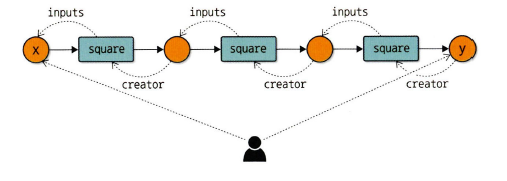

In [45]:
for i in range(10):
    x = Variable(np.random.randn(10000)) # 거대한 데이터
    y = square(square(square(x)))

# 메모리 절약 모드

In [53]:
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
t = add(x0, x1)
y = add(x0, t)
y.backward()

print(y.grad, t.grad)
print(x0.grad, x1.grad)

1.0 1.0
2.0 1.0


y, t의 미분값은 제거

In [54]:
class Variable:
    def __init__(self, data):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{}은(는) 지원하지 않습니다.'.format(type(data)))
        
        self.data = data
        self.grad = None
        self.creator = None
        self.generation = 0 # 세대 수를 기록하는 변수
        
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 # 세대를 기록한다 (부모 세대 + 1).
    def cleargrad(self):
        self.grad = None
        
    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
        funcs = []
        seen_set = set()
        
        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)
                #|print("funcs",funcs)
                #print("seen_set",seen_set)
                
        add_func(self.creator)
        
        while funcs:
            f = funcs.pop() # 함수를 가져온다.
            # gys = [output.grad for output in f.outputs]
            gys = [output().grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)
                
            for x,gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
            
                if x.creator is not None:
                    add_func(x.creator) # 수정 전: funcs.append(x.creator)
            
            if not retain_grad:
                for y in f.outputs:
                    y().grad = None # y는 약한 참조(weakref)

In [55]:
x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
t = add(x0, x1)
y = add(x0, t)
y.backward()

print(y.grad, t.grad)
print(x0.grad, x1.grad)

None None
2.0 1.0


In [56]:
class Config:
    enable_backprop = True

In [83]:
class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs) # 언팩
        if not isinstance(ys, tuple): # 튜플이 아닌 경우 추가
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]
        
        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]
            # 리스트의 원소가 하나라면 첫 번째 원소를 반환
            
        return outputs if len(outputs) > 1 else outputs[0]
    
    def forward(self, x):
        raise NotImplementedError()
        
    def backward(self, gy):
        raise NotImplementedError()

In [58]:
Config.enable_backprop = True
x = Variable(np.ones((100, 100, 100)))
y = square(square(square(x)))
y.backward()

Config.enable_backprop = False
x = Variable(np.ones((100, 100, 100)))
y = square(square(square(x)))

In [59]:
import contextlib

@contextlib.contextmanager
def config_test():
    print('start') # 전처리
    try:
        yield
    finally:
        print('done') # 후처리
        
with config_test():
    print('process...')

start
process...
done


In [60]:
@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)
        
with config_test():
    print('process...')

start
process...
done


In [61]:
with using_config('enable_backprop', False):
    x = Variable(np.array(2.0))
    y = square(x)

In [62]:
def no_grad():
    return using_config('enable_backprop', False)

with no_grad():
    x = Variable(np.array(2.0))
    y = square(x)

# 변수 사용성 개선

In [63]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{}은(는) 지원하지 않습니다.'.format(type(data)))
        
        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0 # 세대 수를 기록하는 변수
        
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 # 세대를 기록한다 (부모 세대 + 1).
    def cleargrad(self):
        self.grad = None
        
    # property가 있으면, shape메서드를 인스턴스 변수처럼 사용할 수 있다.    
    @property
    def shape(self):
        return self.data.shape
    
    @property
    def ndim(self):
        return self.data.ndim
    
    @property
    def size(self):
        return self.data.size
    
    @property
    def dtype(self):
        return self.data.dtype
    
    def __len__(self):
        return len(self.data)
        
    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
        funcs = []
        seen_set = set()
        
        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)
                #|print("funcs",funcs)
                #print("seen_set",seen_set)
                
        add_func(self.creator)
        
        while funcs:
            f = funcs.pop() # 함수를 가져온다.
            # gys = [output.grad for output in f.outputs]
            gys = [output().grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)
                
            for x,gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
            
                if x.creator is not None:
                    add_func(x.creator) # 수정 전: funcs.append(x.creator)
            
            if not retain_grad:
                for y in f.outputs:
                    y().grad = None # y는 약한 참조(weakref)

In [64]:
x = np.array([[1, 2, 3], [4, 5, 6]])
x.shape

(2, 3)

In [65]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
print(x.shape)

(2, 3)


In [66]:
print(x.ndim)
print(x.size)
print(x.dtype)

2
6
int32


In [67]:
print(len(x))

2


In [68]:
x = Variable(np.array([1, 2, 3]))
print(x)

x = Variable(None)
print(x)

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
print(x)

In [104]:
class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{}은(는) 지원하지 않습니다.'.format(type(data)))
        
        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0 # 세대 수를 기록하는 변수
        
    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1 # 세대를 기록한다 (부모 세대 + 1).
    def cleargrad(self):
        self.grad = None
        
    # property가 있으면, shape메서드를 인스턴스 변수처럼 사용할 수 있다.    
    @property
    def shape(self):
        return self.data.shape
    
    @property
    def ndim(self):
        return self.data.ndim
    
    @property
    def size(self):
        return self.data.size
    
    @property
    def dtype(self):
        return self.data.dtype
    
    def __len__(self):
        return len(self.data)
    
    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'
        
    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)
        funcs = []
        seen_set = set()
        
        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)
                #|print("funcs",funcs)
                #print("seen_set",seen_set)
                
        add_func(self.creator)
        
        while funcs:
            f = funcs.pop() # 함수를 가져온다.
            #gys = [output.grad for output in f.outputs]
            gys = [output().grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)
                
            for x,gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx
            
                if x.creator is not None:
                    add_func(x.creator) # 수정 전: funcs.append(x.creator)
            
            if not retain_grad:
                for y in f.outputs:
                    y().grad = None # y는 약한 참조(weakref)

In [105]:
x = Variable(np.array([1, 2, 3]))
print(x)

x = Variable(None)
print(x)

x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
print(x)

variable([1 2 3])
variable(None)
variable([[1 2 3]
          [4 5 6]])


# 연산자 오버로드(1)

In [146]:
import weakref
import numpy as np
import contextlib


class Config:
    enable_backprop = True


@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)


def no_grad():
    return using_config('enable_backprop', False)


class Variable:
    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs):
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    return Add()(x0, x1)


class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0


def mul(x0, x1):
    return Mul()(x0, x1)


Variable.__add__ = add
Variable.__mul__ = mul

a = Variable(np.array(3.0))
b = Variable(np.array(2.0))
c = Variable(np.array(1.0))

# y = add(mul(a, b), c)
y = a * b + c
y.backward()

print(y)
print(a.grad)
print(b.grad)

variable(7.0)
2.0
3.0


# 연산자 오버로드(2)

In [159]:
def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)

In [160]:
class Function:
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs]
        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()

In [161]:
x = Variable(np.array(2.0))
y = x + np.array(3.0)
print(y)

variable(5.0)


In [162]:
def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)

In [163]:
x = Variable(np.array(2.0))
y = x + 3.0
print(y)

variable(5.0)


In [164]:
Variable.__add__ = add
Variable.__radd__ = add
Variable.__mul__ = mul
Variable.__rmul__ = mul

In [165]:
x = Variable(np.array(2.0))
y = 3.0 * x + 1.0
print(y)

variable(7.0)


In [166]:
import weakref
import numpy as np
import contextlib


class Config:
    enable_backprop = True


@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)


def no_grad():
    return using_config('enable_backprop', False)


class Variable:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref


def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs]

        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)


class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0


def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)


Variable.__add__ = add
Variable.__radd__ = add
Variable.__mul__ = mul
Variable.__rmul__ = mul

x = Variable(np.array(2.0))
y = x + np.array(3.0)
print(y)

y = x + 3.0
print(y)

y = 3.0 * x + 1.0
print(y)

variable(5.0)
variable(5.0)
variable(7.0)


In [167]:
import weakref
import numpy as np
import contextlib


class Config:
    enable_backprop = True


@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)


def no_grad():
    return using_config('enable_backprop', False)


class Variable:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]  # output is weakref
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None  # y is weakref


def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs]

        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)


class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0


def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)


class Neg(Function):
    def forward(self, x):
        return -x

    def backward(self, gy):
        return -gy


def neg(x):
    return Neg()(x)


class Sub(Function):
    def forward(self, x0, x1):
        y = x0 - x1
        return y

    def backward(self, gy):
        return gy, -gy


def sub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x0, x1)


def rsub(x0, x1):
    x1 = as_array(x1)
    return sub(x1, x0)


class Div(Function):
    def forward(self, x0, x1):
        y = x0 / x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1 ** 2)
        return gx0, gx1


def div(x0, x1):
    x1 = as_array(x1)
    return Div()(x0, x1)


def rdiv(x0, x1):
    x1 = as_array(x1)
    return div(x1, x0)


class Pow(Function):
    def __init__(self, c):
        self.c = c

    def forward(self, x):
        y = x ** self.c
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        c = self.c

        gx = c * x ** (c - 1) * gy
        return gx


def pow(x, c):
    return Pow(c)(x)


Variable.__add__ = add
Variable.__radd__ = add
Variable.__mul__ = mul
Variable.__rmul__ = mul
Variable.__neg__ = neg
Variable.__sub__ = sub
Variable.__rsub__ = rsub
Variable.__truediv__ = div
Variable.__rtruediv__ = rdiv
Variable.__pow__ = pow

x = Variable(np.array(2.0))
y = -x
print(y)  # variable(-2.0)

y1 = 2.0 - x
y2 = x - 1.0
print(y1)  # variable(0.0)
print(y2)  # variable(1.0)

y = 3.0 / x
print(y)  # variable(1.5)

y = x ** 3
y.backward()
print(y)  # variable(8.0)

variable(-2.0)
variable(0.0)
variable(1.0)
variable(1.5)
variable(8.0)
